# Tensorflow DNN - overview

## import package

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
import pandas as pd
import cv2
import tensorflow as tf

## prepare dataset examples

In [2]:
simpson_img = pd.read_csv('simpson_preproc/simpson_img_list.csv')
print(simpson_img.head())

  classname                         img
0       c34  marge_simpson/pic_0601.jpg
1       c34  marge_simpson/pic_0180.jpg
2       c34  marge_simpson/pic_0196.jpg
3       c34  marge_simpson/pic_0698.jpg
4       c34  marge_simpson/pic_0083.jpg


## plot image example

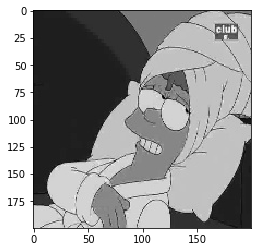

In [3]:
img = cv2.imread('simpson_preproc/' + simpson_img.img.iloc[0], 0)
plt.imshow(img, cmap="gray")

## filter data

In [4]:
simpson_img = simpson_img[simpson_img.img.str.contains('simpson')]

## transform y to one-hot encoder format

In [5]:
simpson_y = pd.get_dummies(simpson_img['classname'], '').as_matrix()
print(simpson_y)

[[0 0 0 0 1 0]
 [0 0 0 0 1 0]
 [0 0 0 0 1 0]
 ..., 
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]
 [1 0 0 0 0 0]]


## information of training data

In [6]:
x_train_list, y_train = simpson_img, simpson_y

## record the dim of img ##
img = cv2.resize(img, (50,50))
img = img.flatten()

print('input_data shape: training {training_shape}'.format(
            training_shape=(len(x_train_list), img.shape[0])))
print('y_true shape: training {training_shape}'.format(
            training_shape=y_train.shape))

input_data shape: training (7274, 2500)
y_true shape: training (7274, 6)


## define image generator

In [7]:
from sklearn.utils import shuffle 

def simpson_train_batch_generator(x, y, bs, shape):
    x_train = np.array([]).reshape((0, shape))
    y_train = np.array([]).reshape((0, y.shape[1]))
    while True:
        new_ind = shuffle(range(len(x)))
        x = x.take(new_ind)
        y = np.take(y, new_ind, axis=0)
        for i in range(len(x)):
            dir_img = 'simpson_preproc/' + x.img.iloc[i]
            img = cv2.imread(dir_img, 0)
            img = cv2.resize(img, (50,50))
            x_train = np.row_stack([x_train, img.flatten()])
            y_train = np.row_stack([y_train, y[i]])
            if x_train.shape[0] == bs:
                x_batch = x_train.copy()
                x_batch /= 255.
                y_batch = y_train.copy()
                x_train = np.array([]).reshape((0 ,shape))
                y_train = np.array([]).reshape((0 ,y.shape[1]))        
                yield x_batch, y_batch

# create graph

In [8]:
tf.reset_default_graph() ## 重新 build graph 需要跑這行

## step 1: define placeholder

In [9]:
#### define placeholder ####
input_data = tf.placeholder(dtype=tf.float32, 
                           shape=[None, img.shape[0]],
                           name='input_data')

y_true = tf.placeholder(dtype=tf.float32, 
                        shape=[None, y_train.shape[1]],
                        name='y_true')

## step 2: create variables and operations

In [10]:
#### define variables(weight/bias) ####
x1 = tf.layers.dense(input_data, 256, activation=tf.nn.sigmoid, name='hidden1')
x2 = tf.layers.dense(x1, 128, activation=tf.nn.sigmoid, name='hidden2')
x3 = tf.layers.dense(x2, 64, activation=tf.nn.sigmoid, name='hidden3')
out = tf.layers.dense(x3, y_train.shape[1], name='output')

y_pred = out

## step 3: define loss function and calculate loss

In [11]:
#### calculate loss ####
loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=y_true, logits=y_pred))

## step 4: define optimizer and define variables update operations

In [12]:
#### optimize variables ####
opt = tf.train.GradientDescentOptimizer(learning_rate=0.001)

update = opt.minimize(loss)

## check global variables (optional)

In [13]:
tf.global_variables() ## 檢查 graph 裏的 global variables

[<tf.Variable 'hidden1/kernel:0' shape=(2500, 256) dtype=float32_ref>,
 <tf.Variable 'hidden1/bias:0' shape=(256,) dtype=float32_ref>,
 <tf.Variable 'hidden2/kernel:0' shape=(256, 128) dtype=float32_ref>,
 <tf.Variable 'hidden2/bias:0' shape=(128,) dtype=float32_ref>,
 <tf.Variable 'hidden3/kernel:0' shape=(128, 64) dtype=float32_ref>,
 <tf.Variable 'hidden3/bias:0' shape=(64,) dtype=float32_ref>,
 <tf.Variable 'output/kernel:0' shape=(64, 6) dtype=float32_ref>,
 <tf.Variable 'output/bias:0' shape=(6,) dtype=float32_ref>]

# run session

## step 1: run global variables initialization

In [14]:
#### init ####
init = tf.global_variables_initializer()

In [15]:
sess = tf.Session()
sess.run(init)

## step 2: run session to update the variables

In [16]:
from tqdm import tqdm_notebook
from sklearn.metrics import accuracy_score

epoch = 30
bs = 32
update_per_epoch = 100

tr_loss = list()
tr_acc = list()
train_gen = simpson_train_batch_generator(x_train_list, y_train, bs, img.shape[0])

print('start modelling!')

for i in range(epoch):
    
    #### calculate training loss & update variables ####
    training_loss = 0
    training_acc = 0
    bar = tqdm_notebook(range(update_per_epoch))
    
    for j in bar:
        
        x_batch, y_batch = next(train_gen)
        
        tr_pred, training_loss_batch, _ = sess.run([y_pred, loss, update], feed_dict={
            input_data:x_batch,
            y_true:y_batch
        })
        
        training_loss += training_loss_batch
        
        training_acc_batch = accuracy_score(np.argmax(y_batch, axis=1), np.argmax(tr_pred, axis=1))
        training_acc += training_acc_batch
        
        if j % 5 == 0:
            bar.set_description('loss: %.4g' % training_loss_batch)

    training_loss /= update_per_epoch
    training_acc /= update_per_epoch
    
    tr_loss.append(training_loss)
    tr_acc.append(training_acc)
    
    print('epoch {epochs}: training loss {training_loss}'.format(
            epochs=(i+1), 
            training_loss=training_loss))


start modelling!


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 1: training loss 1.9307259321212769


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 2: training loss 1.7818112516403197


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 3: training loss 1.7141629683971404


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 4: training loss 1.675211913585663


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 5: training loss 1.653799694776535


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 6: training loss 1.6546723341941834


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 7: training loss 1.6521472179889678


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 8: training loss 1.6337142872810364


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 9: training loss 1.64313157081604


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 10: training loss 1.6326656365394592


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 11: training loss 1.640066225528717


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 12: training loss 1.6331578707695007


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 13: training loss 1.6287528693675994


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 14: training loss 1.6320592629909516


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 15: training loss 1.6276857197284698


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 16: training loss 1.6359973442554474


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 17: training loss 1.629009462594986


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 18: training loss 1.6335417652130126


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 19: training loss 1.6214259374141693


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 20: training loss 1.6248268055915833


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 21: training loss 1.63043572306633


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 22: training loss 1.6290951681137085


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 23: training loss 1.6267518520355224


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 24: training loss 1.6291030037403107


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 25: training loss 1.6279765737056733


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 26: training loss 1.618199690580368


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 27: training loss 1.632375839948654


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 28: training loss 1.6283297550678253


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 29: training loss 1.6283703565597534


HBox(children=(IntProgress(value=0), HTML(value='')))


epoch 30: training loss 1.6266849553585052


## plot model training result

Text(0.5,1,'Accuracy')

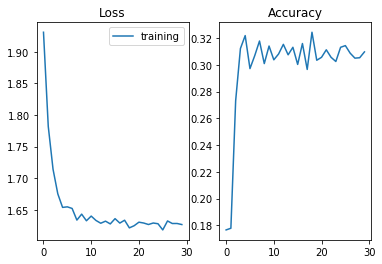

In [17]:
plt.figure(1)
plt.subplot(121)
plt.plot(range(len(tr_loss)), tr_loss, label='training')
plt.title('Loss')
plt.legend(loc='best')
plt.subplot(122)
plt.plot(range(len(tr_acc)), tr_acc, label='training')
plt.title('Accuracy')

## save model

In [18]:
saver = tf.train.Saver()
saver.save(sess, "saved_models/model.ckpt")

'saved_models/model.ckpt'

In [19]:
print(sess.run(loss, feed_dict={
            input_data:x_batch,
            y_true:y_batch
        }))

1.5675


In [20]:
tf.reset_default_graph()
tf.global_variables()

[]

## load model

In [21]:
#rerun the graph
sess = tf.Session()
saver = tf.train.Saver()
saver.restore(sess, "saved_models/model.ckpt")

ValueError: No variables to save

In [ ]:
tf.global_variables()

In [ ]:
print(sess.run(loss, feed_dict={
            input_data:x_batch,
            y_true:y_batch
        }))